In [1]:
%matplotlib inline
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms, utils, models
from torch.autograd import Variable
from tqdm import tqdm_notebook

from skimage import io, transform
import numpy as np
import csv
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')


# from multiprocessing import set_start_method
# try:
#     set_start_method('spawn')
# except RuntimeError:
#     pass

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"]=""
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
torch.cuda.set_device(0) 
torch.backends.cudnn.enabled = True
print(torch.cuda.device_count())
gpus = [0,1]

2


In [2]:
def expand_bbox(left, right, top, bottom, img_width, img_height):
    width = right-left
    height = bottom-top
    ratio = 0.15
    new_left = np.clip(left-ratio*width,0,img_width)
    new_right = np.clip(right+ratio*width,0,img_width)
    new_top = np.clip(top-ratio*height,0,img_height)
    new_bottom = np.clip(bottom+ratio*height,0,img_height)
    return [int(new_left), int(new_top), int(new_right), int(new_bottom)]

In [3]:
%%sh 
jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image_, pose_ = sample['image'], sample['pose']

        h, w = image_.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image_, (new_h, new_w))
        pose = (pose_.reshape([-1,2])/np.array([w,h])*np.array([new_w,new_h])).flatten()
        return {'image': image, 'pose': pose}

class ToTensor(object):

    def __call__(self, sample):
        image, pose = sample['image'], sample['pose']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        mean=np.array([0.485, 0.456, 0.406])
        std=np.array([0.229, 0.224, 0.225])
        image = torch.from_numpy(((image-mean)/std).transpose((2, 0, 1))).float()
        pose = torch.from_numpy(pose).float()
        
        return {'image': image,
                'pose': pose}

class PoseDataset(Dataset):

    def __init__(self, csv_file, transform):
        
        with open(csv_file) as f:
            self.f_csv = list(csv.reader(f, delimiter='\t'))
        self.transform = transform

    def __len__(self):
        return len(self.f_csv)

    def __getitem__(self, idx):
        ROOT_DIR = "/home/yuliang/code/deeppose_tf/datasets/mpii"
        line = self.f_csv[idx][0].split(",")
        img_path = os.path.join(ROOT_DIR,'images',line[0])
        image = io.imread(img_path)
        height, width = image.shape[0], image.shape[1]
        pose = np.array([float(item) for item in line[1:]]).reshape([-1,2])
        
        xmin = np.min(pose[:,0])
        ymin = np.min(pose[:,1])
        xmax = np.max(pose[:,0])
        ymax = np.max(pose[:,1])
        
        box = expand_bbox(xmin, xmax, ymin, ymax, width, height)
        image = image[box[1]:box[3],box[0]:box[2],:]
        pose = (pose-np.array([box[0],box[1]])).flatten()
        
        sample = {'image': image, 'pose':pose}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
ROOT_DIR = "/home/yuliang/code/deeppose_tf/datasets/mpii"

train_dataset = PoseDataset(csv_file=os.path.join(ROOT_DIR,'train_joints.csv'),
                                  transform=transforms.Compose([
                                               Rescale((227,227)),
                                               ToTensor()
                                           ]))
train_dataloader = DataLoader(train_dataset, batch_size=256,
                        shuffle=False, num_workers = 10)

test_dataset = PoseDataset(csv_file=os.path.join(ROOT_DIR,'test_joints.csv'),
                                  transform=transforms.Compose([
                                               Rescale((227,227)),
                                               ToTensor()
                                           ]))
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers = 10)


In [6]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = True
        model.fc=nn.Linear(512,32)
        self.resnet = model
        
    def forward(self, x):
       
        pose_out = self.resnet(x)
        return pose_out

net = Net().cuda(device_id=gpus[0])
criterion = nn.MSELoss().cuda(device_id=gpus[0])
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

In [7]:
def display_pose(img, pose, ids):

    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    pose  = pose.data.cpu().numpy().reshape([-1,2])
    img = img.cpu().numpy().transpose(1,2,0)
    colors = ['g', 'g', 'g', 'g', 'g', 'g', 'm', 'm', 'r', 'r', 'y', 'y', 'y', 'y','y','y']
    pairs = [[8,9],[11,12],[11,10],[2,1],[1,0],[13,14],[14,15],[3,4],[4,5],[8,7],[7,6],[6,2],[6,3],[8,12],[8,13]]
    colors_skeleton = ['r', 'y', 'y', 'g', 'g', 'y', 'y', 'g', 'g', 'm', 'm', 'g', 'g', 'y','y']

    img = img*std+mean
    img_width, img_height,_ = img.shape
    plt.subplot(25,4,ids+1)
    ax = plt.gca()
    plt.imshow(img)
    for idx in range(len(colors)):
        plt.plot(pose[idx,0], pose[idx,1], marker='o', color=colors[idx])
    for idx in range(len(colors_skeleton)):
        plt.plot(pose[pairs[idx],0], pose[pairs[idx],1],color=colors_skeleton[idx])
    xmin = np.min(pose[:,0])
    ymin = np.min(pose[:,1])
    xmax = np.max(pose[:,0])
    ymax = np.max(pose[:,1])
    bndbox = np.array(expand_bbox(xmin, xmax, ymin, ymax, img_width, img_height))
    coords = (bndbox[0], bndbox[1]), bndbox[2]-bndbox[0]+1, bndbox[3]-bndbox[1]+1
    ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='yellow', linewidth=1))

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))












average forward seconds=0.000026 s| fps=38186


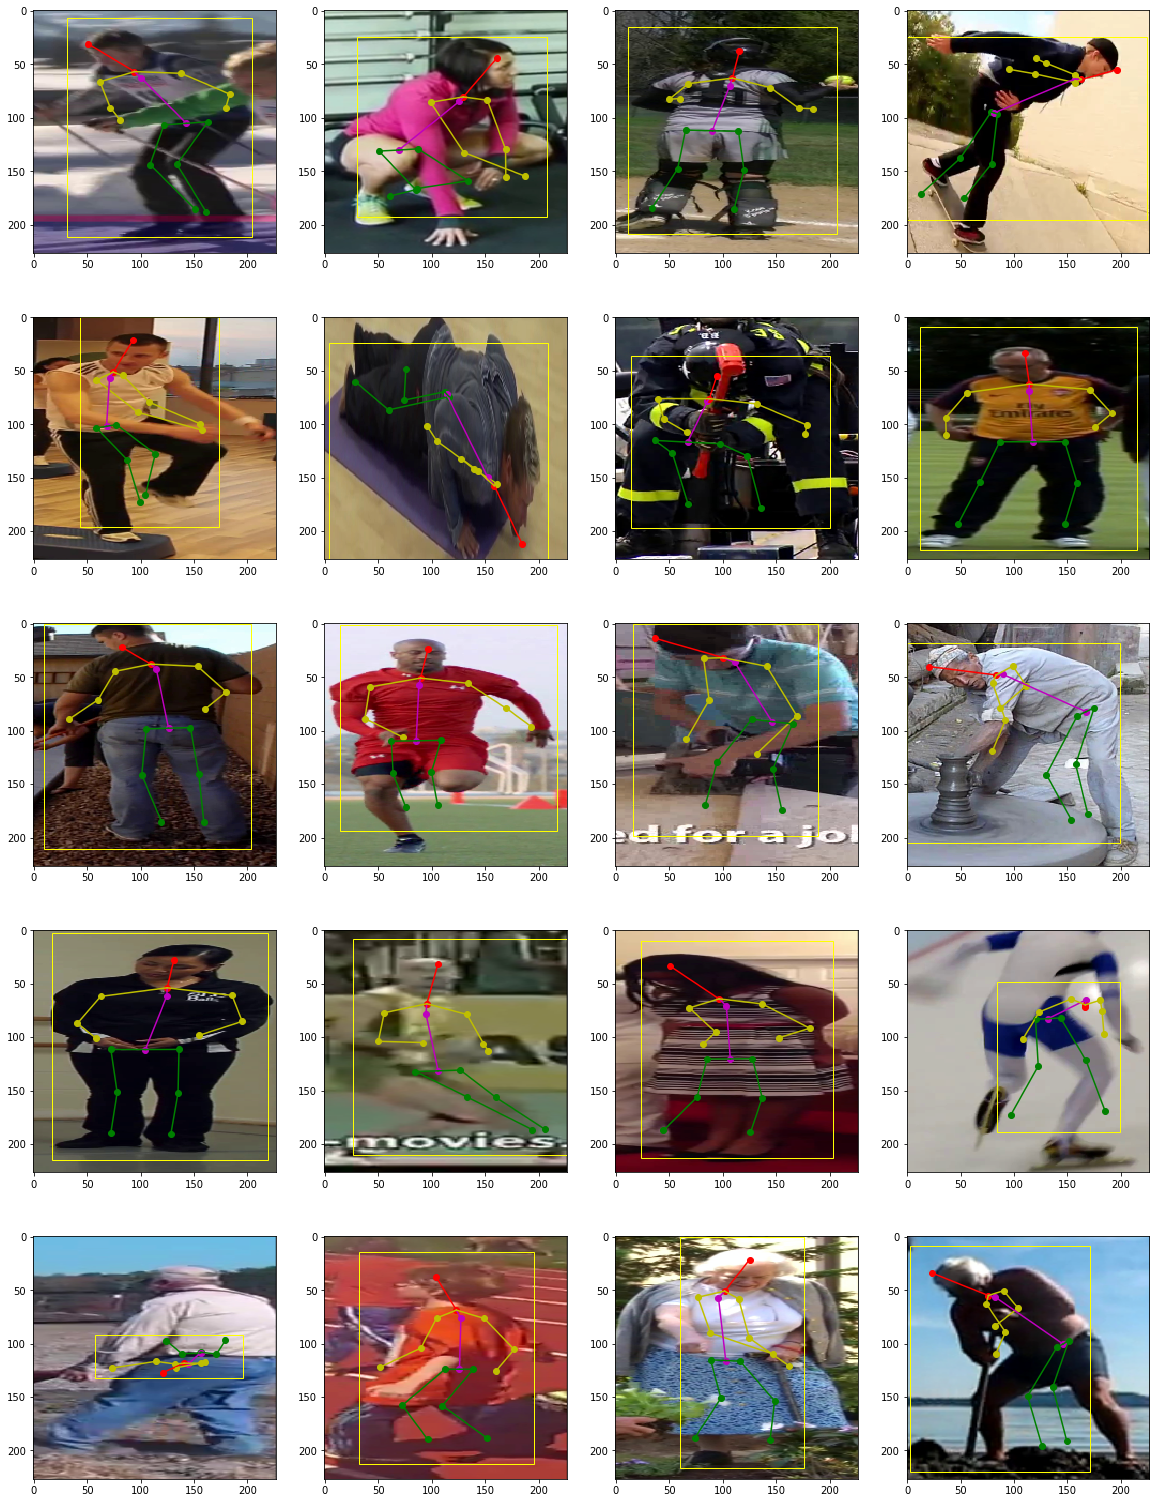

In [14]:
import time
plt.figure(figsize=(20,140))
images = None
poses = None
output = None
for i_batch, sample_batched in enumerate(tqdm_notebook(test_dataloader)):
    net = torch.load('/home/yuliang/code/DeepPose-pytorch-yh/aug-data-same-scale-bz32-checkpoint19.t7').cuda(device_id=gpus[0])
    images = sample_batched['image'].cuda(device=gpus[0])
    poses = sample_batched['pose'].cuda(device=gpus[0])
    t0 = time.clock()
    output = net(Variable(images,volatile=True))
    t1 = time.clock()
    print('average forward seconds=%f s| fps=%d'%((t1-t0)/256,int(1/((t1-t0)/256))))
    for ids in range(20,40):
        display_pose(images[ids],output[ids],ids)
    plt.show()
    
    
    
    break